In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
all_data = pd.read_csv('Datasets/all_data_clean.csv')

In [3]:
all_data

,hash_name,date,price,quantity
0,'Blueberries' Buckshot | NSWC SEAL,2020-12-03,2.501,50
1,'Blueberries' Buckshot | NSWC SEAL,2020-12-04,1.207,1038
2,'Blueberries' Buckshot | NSWC SEAL,2020-12-05,1.185,803
3,'Blueberries' Buckshot | NSWC SEAL,2020-12-06,1.258,541
4,'Blueberries' Buckshot | NSWC SEAL,2020-12-07,1.334,430
...,...,...,...,...
25257188,★ Ursus Knife | Urban Masked (Well-Worn),2024-03-11,125.990,1
25257189,★ Ursus Knife | Urban Masked (Well-Worn),2024-03-14,118.950,1
25257190,★ Ursus Knife | Urban Masked (Well-Worn),2024-03-15,136.634,2
25257191,★ Ursus Knife | Urban Masked (Well-Worn),2024-03-16,118.137,1


In [4]:
all_data['date'] = pd.to_datetime(all_data['date'])

In [5]:
grouped = all_data.groupby('hash_name')

# Create a dictionary to store DataFrames for each hash_name with date as index
dfs = {}

# Iterate over each group and store it in the dictionary with date as index
for name, group_df in grouped:
    # Convert 'date' column to datetime
    group_df['date'] = pd.to_datetime(group_df['date'])
    
    # Set 'date' column as index
    group_df.set_index('date', inplace=True)

    # Store the DataFrame in the dictionary
    dfs[name] = group_df

In [6]:
dfs["'Blueberries' Buckshot | NSWC SEAL"]

,hash_name,price,quantity
date,,,
2020-12-03,'Blueberries' Buckshot | NSWC SEAL,2.501000,50
2020-12-04,'Blueberries' Buckshot | NSWC SEAL,1.207000,1038
2020-12-05,'Blueberries' Buckshot | NSWC SEAL,1.185000,803
2020-12-06,'Blueberries' Buckshot | NSWC SEAL,1.258000,541
2020-12-07,'Blueberries' Buckshot | NSWC SEAL,1.334000,430
...,...,...,...
2024-03-22,'Blueberries' Buckshot | NSWC SEAL,9.153619,51
2024-03-23,'Blueberries' Buckshot | NSWC SEAL,9.386526,53
2024-03-24,'Blueberries' Buckshot | NSWC SEAL,9.251524,59


In [7]:
train_test_dfs = {}

# Ratio for train-test split
train_size_ratio = 0.8  # 80% for train set

# Iterate over each DataFrame in the dictionary
for name, df in dfs.items():
    # Calculate the index to split the data
    split_index = int(len(df) * train_size_ratio)
    
    # Split the DataFrame into train and test sets
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    
    # Store the train and test sets in the dictionary
    train_test_dfs[name] = {'train_df': train_df, 'test_df': test_df}

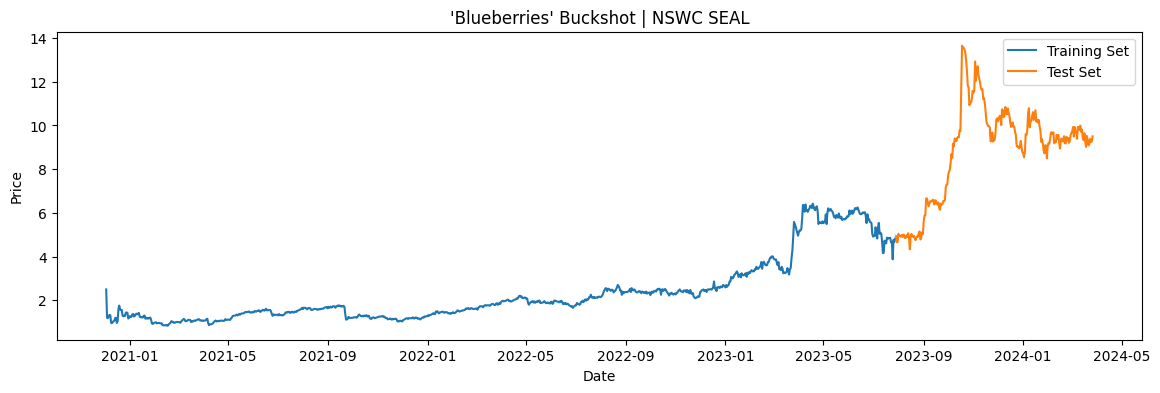

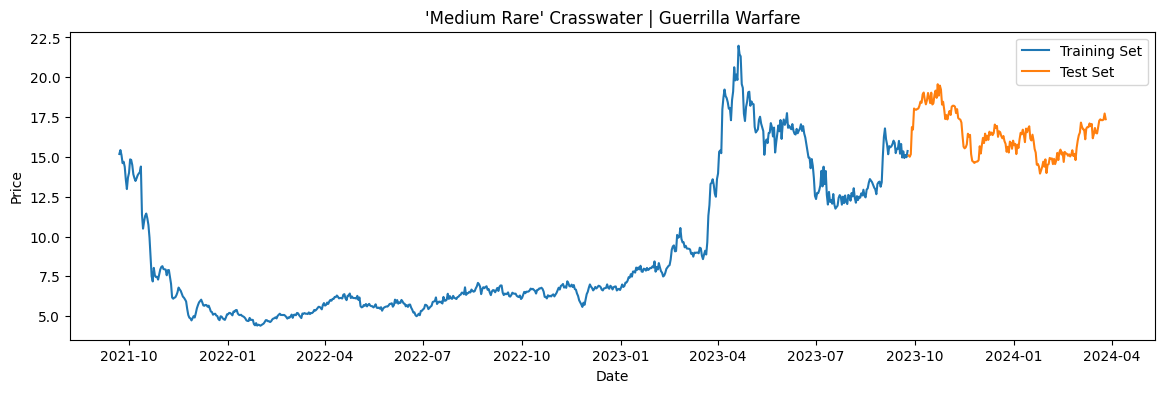

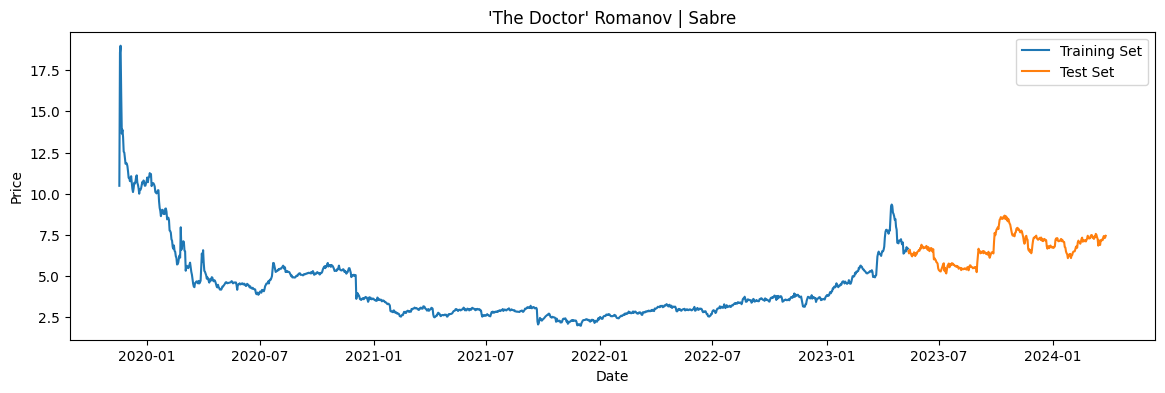

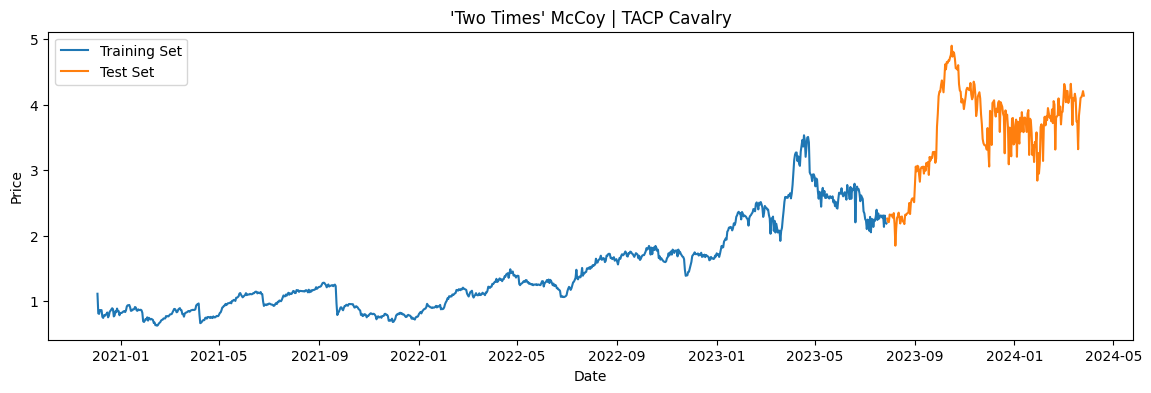

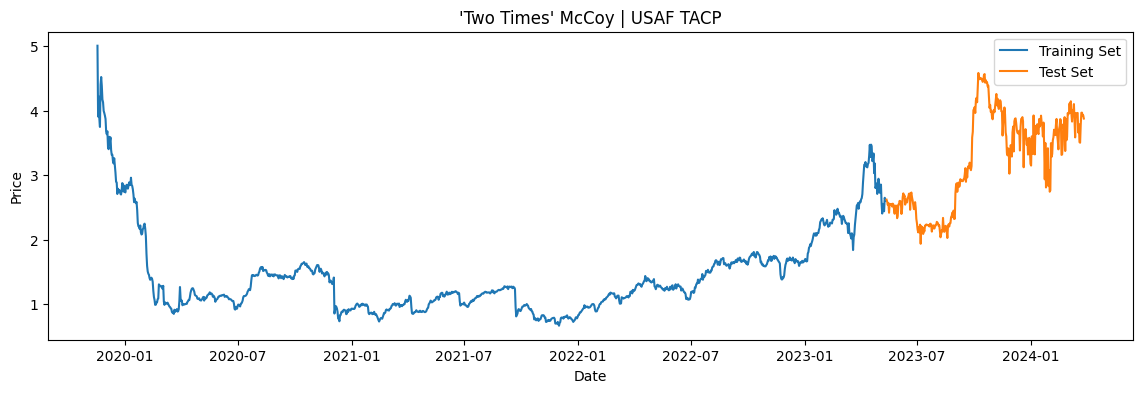

In [8]:
import matplotlib.pyplot as plt

# Plot train and test sets for the first 5 stocks
for name, data in list(train_test_dfs.items())[:5]:
    train_df = data['train_df']
    test_df = data['test_df']
    
    # Plot
    plt.figure(figsize=(14,4))
    plt.plot(train_df['price'], label="Training Set")
    plt.plot(test_df['price'], label="Test Set")
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend()
    plt.title(name)
    plt.show()

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Dictionary to store trained models
trained_models = {}

# Iterate over each group in train_test_dfs
for idx, (name, data) in enumerate(train_test_dfs.items()):
    if idx >= 5:
        break
    # Extract train and test DataFrames
    train_df = data['train_df'][['price']]
    test_df = data['test_df'][['price']]
    
    # Preprocess the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data = scaler.fit_transform(train_df.values.reshape(-1, 1))
    test_data = scaler.transform(test_df.values.reshape(-1, 1))
    
    # Define function to create LSTM dataset
    def create_dataset(dataset, time_steps=1):
        X, y = [], []
        for i in range(len(dataset) - time_steps):
            X.append(dataset[i:(i + time_steps), 0])
            y.append(dataset[i + time_steps, 0])
        return np.array(X), np.array(y)
    
    # Create LSTM dataset
    time_steps = 128  # Adjust as needed
    X_train, y_train = create_dataset(train_data, time_steps)
    X_test, y_test = create_dataset(test_data, time_steps)
    
    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1)
    
    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'{name} - Training Loss: {train_loss}, Testing Loss: {test_loss}')
    
    # Store trained model
    trained_models[name] = model


Epoch 1/60


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0428
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0028
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0019
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0026
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0020
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0019
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0013
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0017
Epoch 9/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0012
Epoch 10/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0014
Epoch 11/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0014
Epoch 12/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0015
Epoch 13/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0013
Epoch 14/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0012
Epoch 15/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0013
Epoch 16/60
27/

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0713
Epoch 2/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0069
Epoch 3/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0030
Epoch 4/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0024
Epoch 5/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0022
Epoch 6/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0024
Epoch 7/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0019
Epoch 8/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0018
Epoch 9/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0021
Epoch 10/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0016
Epoch 11/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0015
Epoch 12/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0015
Epoch 13/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0014
Epoch 14/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0014
Epoch 15/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0012
Epoch 16/60
19/

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0049
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 4.0640e-04
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.9198e-04
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.2248e-04
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.5659e-04
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.5563e-04
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.5762e-04
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 2.6265e-04
Epoch 9/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.5233e-04
Epoch 10/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.7978e-04
Epoch 11/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.6146e-04
Epoch 12/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.6653e-04
Epoch 13/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.5678e-04
Epoch 14/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.0536e-04
Epoch 15/60
36/36 ━━━━━━━━━━━━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0430
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0026
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0018
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0018
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0014
Epoch 9/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013
Epoch 10/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0014
Epoch 11/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0011
Epoch 12/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014
Epoch 13/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0013
Epoch 14/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0012
Epoch 15/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 9.4326e-04
Epoch 16/60

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0092
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 9.0082e-04
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 6.6850e-04
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 5.6293e-04
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 4.6156e-04
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 4.5086e-04
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.8579e-04
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.7372e-04
Epoch 9/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 3.5774e-04
Epoch 10/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.3807e-04
Epoch 11/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.5852e-04
Epoch 12/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.2416e-04
Epoch 13/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 3.7509e-04
Epoch 14/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.2267e-04
Epoch 15/60
36/36 ━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


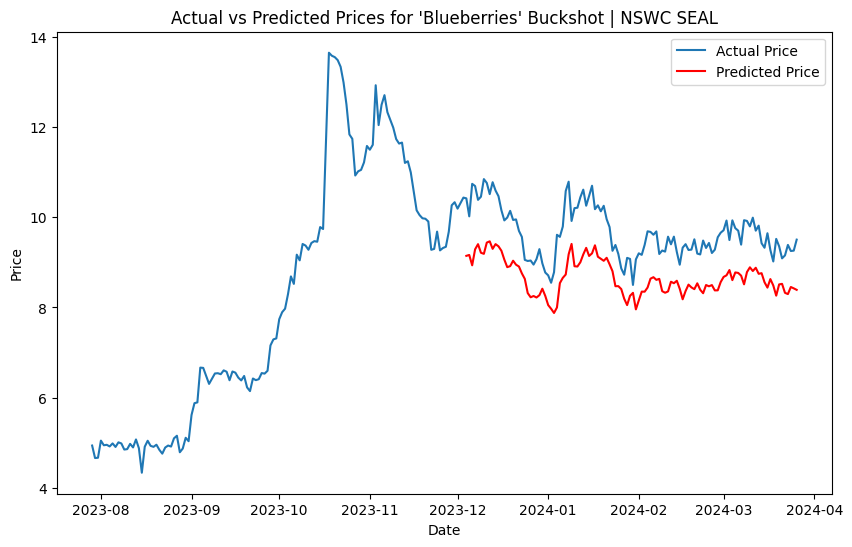

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


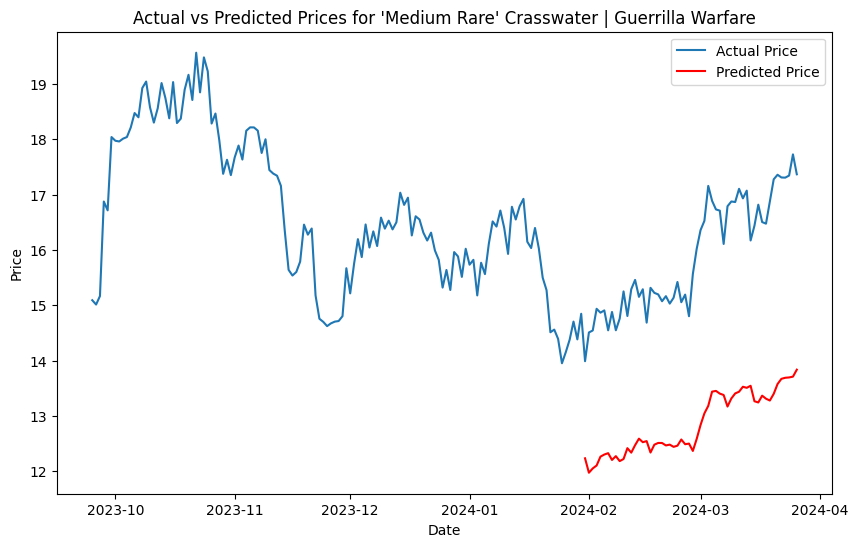

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3c3347420> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


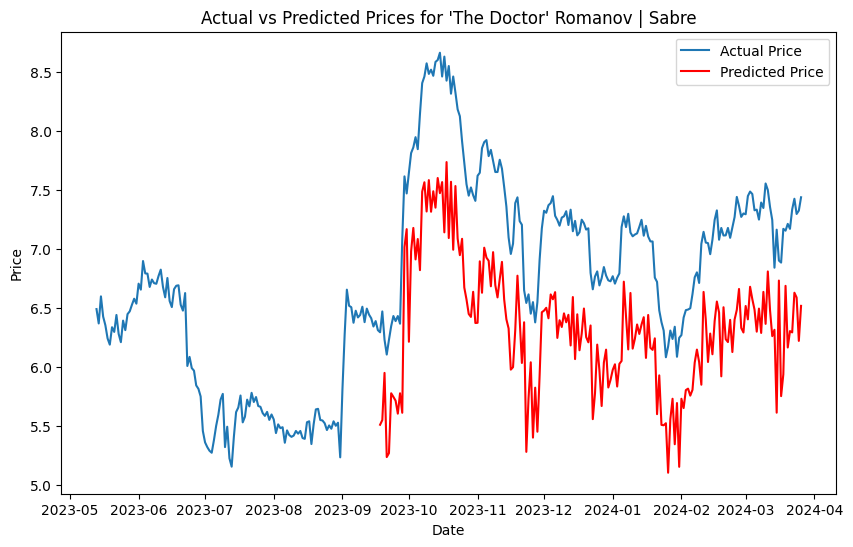

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


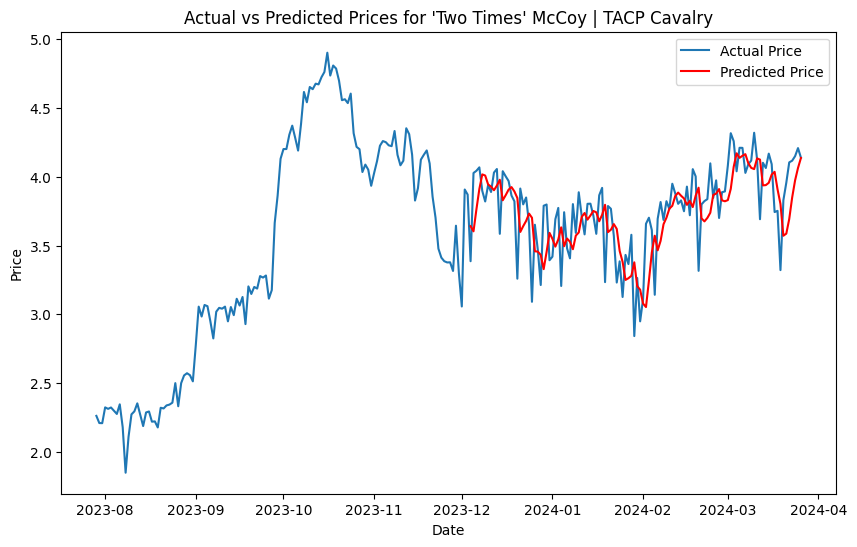

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


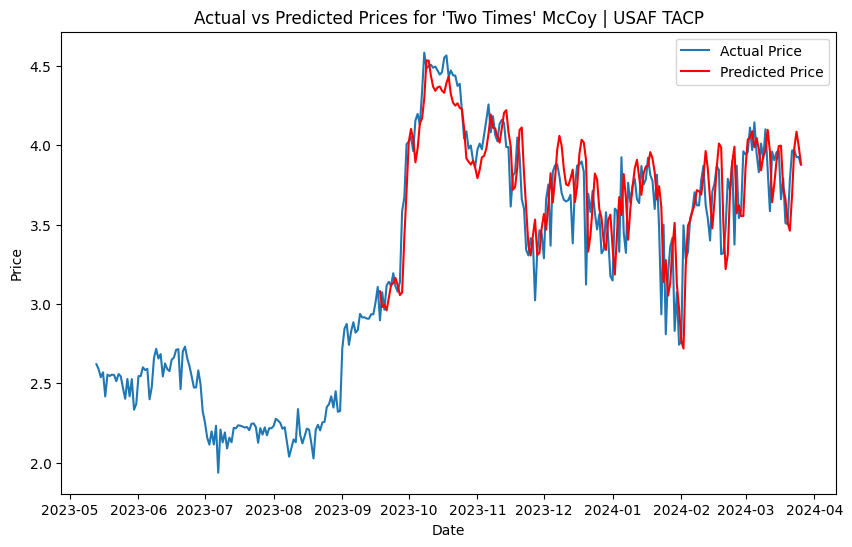

In [10]:
import matplotlib.pyplot as plt

# Iterate over each group in trained_models
for name, model in trained_models.items():
    # Extract test DataFrame
    test_df = train_test_dfs[name]['test_df']
    
    # Preprocess test data for prediction
    test_data = scaler.transform(test_df['price'].values.reshape(-1, 1))
    X_test, y_test = create_dataset(test_data, time_steps)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    
    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(test_df.index, test_df['price'], label='Actual Price')
    plt.plot(test_df.index[time_steps:], predictions, label='Predicted Price', color='red')
    plt.title(f'Actual vs Predicted Prices for {name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
